<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Отчет по проекту "Идентификация пользователей по посещенным веб-страницам"

# 1. Цели и задачи проекта, описание исходных и обработанных данных и признаков.

В этом проекте мы будем решать задачу идентификации пользователя по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. В двух словах, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду. Этот пилотный проект описан в статье на Хабрахабре. Похожие вещи делаются, например, в Google Analytics и описываются в научных статьях, найти можно многое по фразам "Traversal Pattern Mining" и "Sequential Pattern Mining".

Мы будем решать похожую задачу: по последовательности из нескольких веб-сайтов, посещенных подряд один и тем же человеком, мы будем идентифицировать этого человека. Идея такая: пользователи Интернета по-разному переходят по ссылкам, и это может помогать их идентифицировать (кто-то сначала в почту, потом про футбол почитать, затем новости, контакт, потом наконец – работать, кто-то – сразу работать).

Данные пришли с прокси-серверов Университета Блеза Паскаля и имеют очень простой вид. Для каждого пользователя заведен csv-файл с названием user****.csv (где вместо звездочек – 4 цифры, соответствующие ID пользователя), а в нем посещения сайтов записаны в следующем формате:

*timestamp, посещенный веб-сайт*

В обучающей выборке **train_sessions_400users.csv** признаки **site_i** – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем **site_dic.pkl**).
Признаки **time_j** – время посещения сайтов **site_j**.

Целевой признак **user_id** – ID, пользователя, которому принадлежит сессия из 10 посещений веб-сайтов.

Задача – сделать прогнозы для сессий в тестовой выборке (**test_sessions_400users.csv**), определить, каким пользователям они принадлежат.

Не обязательно ограничиваться только предложенной выборкой **train_sessions_400users.csv** – в **train.zip** даны исходные данные о посещенных пользователями веб-страницах, по которым можно сформировать свою обучающую выборку.

In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, hstack
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV

In [4]:
PATH_TO_DATA = 'data' 

In [15]:
time_columns = ['time{}'.format(i) for i in range(1, 11)]

train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id', 
                       parse_dates=time_columns)
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id', 
                      parse_dates=time_columns)

In [16]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [17]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [18]:
train_df_sorted = train_df.sort_values('time1')
train_test_df = pd.concat([train_df, test_df])

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   site1   253561 non-null  int64         
 1   time1   253561 non-null  datetime64[ns]
 2   site2   250098 non-null  float64       
 3   time2   250098 non-null  datetime64[ns]
 4   site3   246919 non-null  float64       
 5   time3   246919 non-null  datetime64[ns]
 6   site4   244321 non-null  float64       
 7   time4   244321 non-null  datetime64[ns]
 8   site5   241829 non-null  float64       
 9   time5   241829 non-null  datetime64[ns]
 10  site6   239495 non-null  float64       
 11  time6   239495 non-null  datetime64[ns]
 12  site7   237297 non-null  float64       
 13  time7   237297 non-null  datetime64[ns]
 14  site8   235224 non-null  float64       
 15  time8   235224 non-null  datetime64[ns]
 16  site9   233084 non-null  float64       
 17  time9   233084 non-null  datetime6

In [20]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   site1   82797 non-null  int64         
 1   time1   82797 non-null  datetime64[ns]
 2   site2   81308 non-null  float64       
 3   time2   81308 non-null  datetime64[ns]
 4   site3   80075 non-null  float64       
 5   time3   80075 non-null  datetime64[ns]
 6   site4   79182 non-null  float64       
 7   time4   79182 non-null  datetime64[ns]
 8   site5   78341 non-null  float64       
 9   time5   78341 non-null  datetime64[ns]
 10  site6   77566 non-null  float64       
 11  time6   77566 non-null  datetime64[ns]
 12  site7   76840 non-null  float64       
 13  time7   76840 non-null  datetime64[ns]
 14  site8   76151 non-null  float64       
 15  time8   76151 non-null  datetime64[ns]
 16  site9   75484 non-null  float64       
 17  time9   75484 non-null  datetime64[ns]
 18  site10  748

In [22]:
train_df['target'].value_counts()

target
0    251264
1      2297
Name: count, dtype: int64

In [23]:
with open(os.path.join(PATH_TO_DATA, 'site_dic.pkl'), 'rb') as f:
    site_dic = pickle.load(f)

list(site_dic.items())[:10]

[('www.abmecatronique.com', 25075),
 ('groups.live.com', 13997),
 ('majeureliguefootball.wordpress.com', 42436),
 ('cdt46.media.tourinsoft.eu', 30911),
 ('www.hdwallpapers.eu', 8104),
 ('img378.imageshack.us', 37491),
 ('ecologie.nature.free.fr', 5462),
 ('www.ibcn.intec.ugent.be', 35425),
 ('kissanime.com', 30151),
 ('www.carolineconduiteformation.com', 38268)]

In [24]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [25]:
train_test_df_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178


In [26]:
def transform_to_csr_matrix(X):
    """Converts the matrix to a sparse format"""
    
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for session in X.values:
        for site in session:
            index = vocabulary.setdefault(site, site)
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))
        
    return csr_matrix((data, indices, indptr))[:, 1:]

In [27]:
train_test_sparse = transform_to_csr_matrix(train_test_df_sites)
X_train_sparse = train_test_sparse[:train_df.shape[0], :]
X_test_sparse = train_test_sparse[train_df.shape[0]:, :]
# Выделим в отдельный вектор y ответы на обучающей выборке.
y = train_df.target.values

In [28]:
print('X_train_sparse shape: {} X_test_sparse shape: {}'.format(X_train_sparse.shape, 
                                                                X_test_sparse.shape))

X_train_sparse shape: (253561, 48371) X_test_sparse shape: (82797, 48371)


In [29]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

In [30]:
sgd_logit = SGDClassifier(loss='log', random_state=17, n_jobs=-1)
sgd_logit.fit(X_train, y_train)

SGDClassifier(loss='log', n_jobs=-1, random_state=17)

In [31]:
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)[:, 1]

In [32]:
valid_roc_auc = round(roc_auc_score(y_valid, logit_valid_pred_proba), 3)
print('Baseline valid ROC AUC score: {}'.format(valid_roc_auc))

Baseline valid ROC AUC score: 0.934


In [33]:
def feature_engineering(X, train=True):
    '''
    
    Creating new features:
    - session_timespan;
    - #unique_sites;
    - start_hour;
    - day_of_week;
    - time_diff1 - time_diff9. 
    
    '''
    sites = X[['site{}'.format(i) for i in range(1, 11)]].fillna(0).astype('int').values
    times = X[['time{}'.format(i) for i in range(1, 11)]]
    new_features = pd.DataFrame()
    
    for i in range(1, 10):
        new_features['time_diff{}'.format(i)] = ( 
            (pd.to_datetime(times['time{}'.format(i + 1)]) \
            - pd.to_datetime(times['time{}'.format(i)]))).dt.total_seconds().fillna(0)
        
    new_features['session_timespan'] = np.sum(new_features, axis=1)
    new_features['#unique_sites'] = [len(np.unique(session[session != 0])) 
                                     for session in sites]
    new_features['start_hour'] = pd.to_datetime(times['time1']).dt.hour
    new_features['day_of_week'] = pd.to_datetime(times['time1']).dt.weekday
    if train:
        new_features['target'] = X.target
    
    return new_features

In [34]:
new_train_features = feature_engineering(train_df)
new_test_features = feature_engineering(test_df, train=False)

In [35]:
targets_data = [new_train_features[new_train_features['target']==i] for i in (0, 1)]

colors = ['red', 'blue']
labels = ['Other', 'Alice']

Распределение признака #unique_sites:


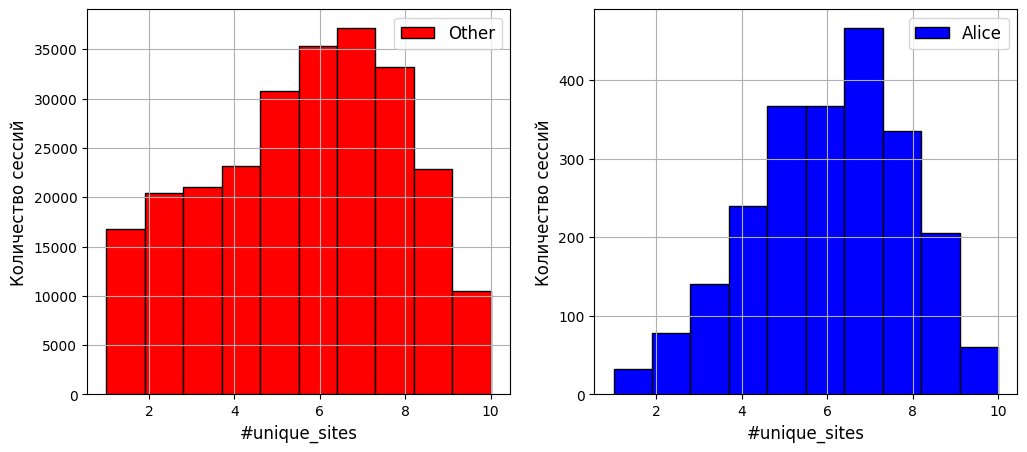

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for i, target in enumerate(targets_data):
    axs[i].hist(target['#unique_sites'], bins=10, 
                color=colors[i], edgecolor='black', 
                label=labels[i])
    axs[i].grid(True)
    axs[i].legend(fontsize='large')
    axs[i].set_xlabel('#unique_sites', fontsize='large')
    axs[i].set_ylabel('Количество сессий', fontsize='large')
    
print('Распределение признака #unique_sites:')

Распределение признака start_hour:


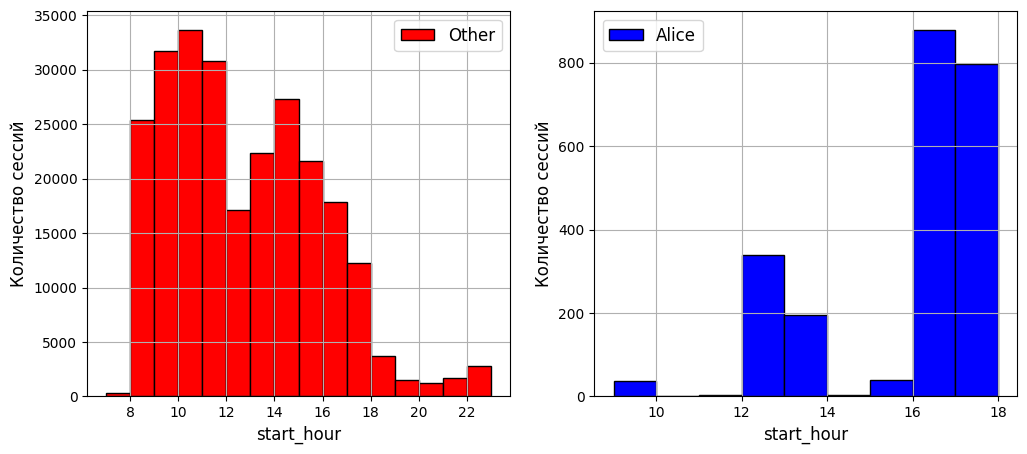

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for i, target in enumerate(targets_data):
    axs[i].hist(target['start_hour'], 
                bins=target['start_hour'].max() - \
                target['start_hour'].min(), 
                color=colors[i], edgecolor='black', 
                label=labels[i])
    axs[i].grid(True)
    axs[i].legend(fontsize='large')
    axs[i].set_xlabel('start_hour', fontsize='large')
    axs[i].set_ylabel('Количество сессий', fontsize='large')
    
print('Распределение признака start_hour:')

Распределение признака day_of_week:


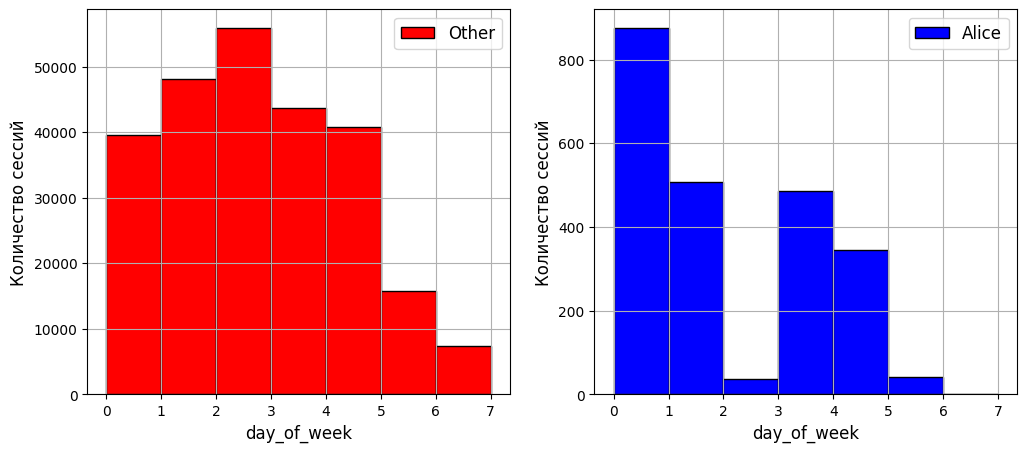

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for i, target in enumerate(targets_data):
    axs[i].hist(target['day_of_week'], 
                bins=7, range=(0, 7), color=colors[i], 
                edgecolor='black', label=labels[i])
    axs[i].grid(True)
    axs[i].legend(fontsize='large')
    axs[i].set_xlabel('day_of_week', fontsize='large')
    axs[i].set_ylabel('Количество сессий', fontsize='large')
    
print('Распределение признака day_of_week:')

In [39]:
def feature_engineering2(X):
    '''
    
    Creating new features:
    - weekend;
    - time_of_day.
    
    '''
    
    time1 = X['time1']
    new_features = pd.DataFrame() 
    
    # Введем вспомогательную функцию для вычисления признака time_of_day.
    def time_of_day(hour):
        if 0 <= hour < 6:
            return 0
        elif 6 <= hour < 12:
            return 1
        elif 12 <= hour < 18:
            return 2
        elif 18 <= hour:
            return 3
    
    new_features['weekend'] = time1.dt.weekday.isin((5, 6))
    new_features['time_of_day'] = time1.dt.hour.apply(time_of_day)
    
    return new_features